In [2]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from timm.models import create_model
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from PIL import Image

In [3]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super(PatchEmbed, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(
            in_channels=in_chans,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )  # Embedding dim으로 변환하며 패치크기의 커널로 패치크기만큼 이동하여 이미지를 패치로 분할 할 수 있음.

    def forward(self, x):
        x = self.proj(x)  # (batch_size, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)  # 세번째 차원부터 끝까지 flatten (batch_size, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (batch_size, n_patches, embed_dim)
        return x

In [4]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super(Attention, self).__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5  # 1 / root(self.head_dim)
        '''
        # 나중에 query와 key를 곱하고 softmax를 취하기전에 scale factor로 나눠주는데 이 scale factor의 역할은 
        query @ key 의 값이 커지게 되면 softmax 함수에서의 기울기 변화가 거의 없는 부분으로 가기때문에 gradient vanishing
        문제를 해결하려면 scaling을 해주어야 한다고 Attention is all you need 논문에서 주장
         
        '''
        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  # (n_samples, n_patches+1, dim*3)
        qkv = qkv.reshape(
            n_samples, n_tokens, 3, self.n_heads, self.head_dim
        )  # (n_samples, n_patches+1, 3, n_heads, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, n_samples, n_heads, n_patches+1, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]  # 각각의 n_heads끼리 query, key, value로 나눔
        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches+1)  dot product를 위한 transpose
        # dot product를 통해 query와 key사이의 유사도를 구함
        dp = (q @ k_t) * self.scale  # (n_samples, n_heads, n_patches+1, n_patches+1)  @: dot product (2x1)@(1x2)=(2x2)
        attn = dp.softmax(dim=-1)  # attention (n_samples, n_heads, n_patches+1, n_patches+1)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches+1, head_dim)
        # 원래 차원으로 되돌림.
        weighted_avg = weighted_avg.transpose(1, 2)  # (n_samples, n_patches+1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # concat (n_samples, n_patches+1, dim)

        x = self.proj(weighted_avg)  # linear projection (n_samples, n_patches+1, dim)
        x = self.proj_drop(x)
        return x

In [5]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [6]:
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super(Block, self).__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
            dim,
            n_heads=n_heads,
            qkv_bias=qkv_bias,
            attn_p=attn_p,
            proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)  # 3072(MLP size)
        self.mlp = MLP(
            in_features=dim,
            hidden_features= hidden_features,
            out_features=dim,
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [7]:
class VisionTransformer(nn.Module):
    def __init__(
            self,
            img_size=384,
            patch_size=16,
            in_chans=3,
            n_classes=1000,
            embed_dim=768,
            depth=12,
            n_heads=12,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.):
        super(VisionTransformer, self).__init__()

        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)  # 12개의 block
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)  # (n_samples, n_patches, embed_dim)
        cls_token = self.cls_token.expand(n_samples, -1, -1)  # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1+n_patches, embed_dim)
        x = x + self.pos_embed  # (n_samples, 1+n_patches, embed_dim)
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)  # (n_samples, 577, 768)

        x = self.norm(x)

        cls_token_final = x[:, 0]  # just tje CLS token
        x = self.head(cls_token_final)

        return x

In [10]:
if __name__ == '__main__':
    from torchsummary import summary

    custom_config = {
        "img_size": 384,
        "in_chans": 3,
        "patch_size": 16,
        "embed_dim": 768,
        "depth": 12,
        "n_heads": 12,
        "qkv_bias": True,
        "mlp_ratio": 4
    }
    model_custom = VisionTransformer(**custom_config)

    inp = torch.rand(2, 3, 384, 384)
    res_c = model_custom(inp)
    print(res_c.shape)

    summary(model_custom, input_size=(3, 384, 384), device='cpu')
    print(model_custom)

torch.Size([2, 1000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 24, 24]         590,592
        PatchEmbed-2             [-1, 576, 768]               0
           Dropout-3             [-1, 577, 768]               0
         LayerNorm-4             [-1, 577, 768]           1,536
            Linear-5            [-1, 577, 2304]       1,771,776
           Dropout-6         [-1, 12, 577, 577]               0
            Linear-7             [-1, 577, 768]         590,592
           Dropout-8             [-1, 577, 768]               0
         Attention-9             [-1, 577, 768]               0
        LayerNorm-10             [-1, 577, 768]           1,536
           Linear-11            [-1, 577, 3072]       2,362,368
             GELU-12            [-1, 577, 3072]               0
          Dropout-13            [-1, 577, 3072]               0
           Linear

In [31]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import timm



In [35]:
import numpy as np
from PIL import Image
import torch.nn.functional
import cv2

k = 10  # 상위 10개

# ImageNet 1000 클래스 레이블 파일 열기
imagenet_labels = dict(enumerate(open("C:\\Users\\baekj\\Downloads\\classes.txt")))

# 모델 다운로드 (vit_base_patch16_384)
model = timm.create_model('vit_base_patch16_384', pretrained=True)
model.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

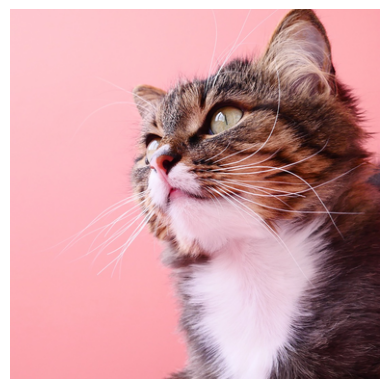

0: tabby, tabby_cat                              --- 0.8001
1: tiger_cat                                     --- 0.1752
2: Egyptian_cat                                  --- 0.0172
3: lynx, catamount                               --- 0.0018
4: Persian_cat                                   --- 0.0011
5: Siamese_cat, Siamese                          --- 0.0002
6: bow_tie, bow-tie, bowtie                      --- 0.0002
7: weasel                                        --- 0.0001
8: lens_cap, lens_cover                          --- 0.0001
9: remote_control, remote                        --- 0.0001


In [37]:
import matplotlib.pyplot as plt

# PNG 이미지 파일 열기
img = Image.open("C:\\Users\\baekj\\Downloads\\cat.png")

# 이미지 출력
plt.imshow(img)
plt.axis('off')  # 축 제거
plt.show()



# 이미지 전처리
img = (np.array(img)/128) - 1  # -1~1 
img = cv2.resize(img, (384, 384))
inp = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(torch.float32)
logits = model(inp)
probs = torch.nn.functional.softmax(logits, dim=1)

top_probs, top_idxs = probs[0].topk(k)

for i, (idx_, prob_) in enumerate(zip(top_idxs, top_probs)):
    idx = idx_.item()
    prob = prob_.item()
    cls = imagenet_labels[idx].strip()
    print(f"{i}: {cls:<45} --- {prob:.4f}")

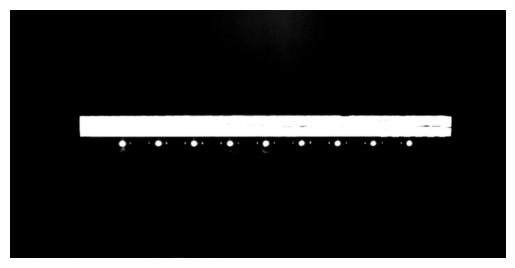

0: rule, ruler                                   --- 0.2658
1: radiator                                      --- 0.0762
2: syringe                                       --- 0.0467
3: nail                                          --- 0.0399
4: spotlight, spot                               --- 0.0378
5: digital_clock                                 --- 0.0359
6: screw                                         --- 0.0335
7: modem                                         --- 0.0254
8: bannister, banister, balustrade, balusters, handrail --- 0.0203
9: hook, claw                                    --- 0.0190


In [38]:
import matplotlib.pyplot as plt

# PNG 이미지 파일 열기
img = Image.open("C:\\Users\\baekj\\Downloads\\crack.jpg")

# 이미지 출력
plt.imshow(img)
plt.axis('off')  # 축 제거
plt.show()



# 이미지 전처리
img = (np.array(img)/128) - 1  # -1~1 
img = cv2.resize(img, (384, 384))
inp = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(torch.float32)
logits = model(inp)
probs = torch.nn.functional.softmax(logits, dim=1)

top_probs, top_idxs = probs[0].topk(k)

for i, (idx_, prob_) in enumerate(zip(top_idxs, top_probs)):
    idx = idx_.item()
    prob = prob_.item()
    cls = imagenet_labels[idx].strip()
    print(f"{i}: {cls:<45} --- {prob:.4f}")